In [2]:
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import platform
import matplotlib.patches as patches

# 1. Set Project Root Path
# Determine if the notebook is running from root or 'notebooks' folder
current_dir = Path(os.getcwd())
if current_dir.name == 'notebooks':
    PROJECT_ROOT = current_dir.parent
else:
    PROJECT_ROOT = current_dir

# Add project root to system path to allow module imports
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# 2. Import Config & Custom Modules
try:
    import config.config as cfg
    from src.data.loader import load_raw_data
    from src.features.engineering import FeatureEngineer
    from src.models.trainer import PitchRecommendationTrainer
    from src.models.location_trainer import PitchLocationTrainer
    from src.recommendation.recommender import PitchRecommender
    print("Custom modules imported successfully.")
except ImportError as e:
    print(f" Import Error: {e}")
    print("   Please make sure you are in the correct directory and the 'src' folder exists.")

# 3. Visualization Settings (Font support for M4 Mac/Windows)
system_os = platform.system()
if system_os == 'Darwin': # Mac
    plt.rcParams['font.family'] = 'AppleGothic'
elif system_os == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    plt.rcParams['font.family'] = 'sans-serif'

plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid", font=plt.rcParams['font.family'])

print(f"Visualization settings configured for {system_os}.")
print(f"Project Root set to: {PROJECT_ROOT}")

Custom modules imported successfully.
Visualization settings configured for Darwin.
Project Root set to: /Users/songdongseon/projects/prototype


In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Path to RE288 table
re_path = cfg.PROCESSED_DATA_DIR / "re288_table.csv"
re_matrix = {}

# 1. Load Data
if re_path.exists():
    try:
        re_df = pd.read_csv(re_path)
        # Key: "B-S-O-1B-2B-3B"
        re_matrix = dict(zip(re_df['state'], re_df['re_value']))
        print(f"[INFO] Successfully loaded RE288 table with {len(re_matrix)} states.")
    except Exception as e:
        print(f"[ERROR] Failed to read CSV: {e}")
else:
    print("[WARNING] RE288 table file not found. Using limited fallback data.")
    # Fallback for demo (Simple heuristic if file missing)
    # ... (omitted for brevity, same as before) ...

# 2. Interactive Visualization Function
def plot_re_heatmap(outs, runners):
    """
    outs: 0, 1, 2
    runners: 'Empty', '1B', '2B', '3B', '1B, 2B', ...
    """
    # Runner String to Code Mapping
    runner_map = {
        'Empty': '0-0-0',
        '1B': '1-0-0', '2B': '0-1-0', '3B': '0-0-1',
        '1B, 2B': '1-1-0', '1B, 3B': '1-0-1', '2B, 3B': '0-1-1',
        'Bases Loaded': '1-1-1'
    }
    runner_code = runner_map.get(runners, '0-0-0')
    
    # Grid for 3 Strikes x 4 Balls
    heatmap_data = np.zeros((3, 4)) 
    
    for b in range(4):
        for s in range(3):
            # Construct Key: B-S-O-R1-R2-R3
            key = f"{b}-{s}-{outs}-{runner_code}"
            
            if key in re_matrix:
                heatmap_data[s, b] = re_matrix[key]
            else:
                # Fallback: Estimation if key missing in sample
                # (Just for visualization safety)
                base = 0.5
                if '1-1-1' in runner_code: base += 1.5
                elif '1' in runner_code: base += 0.5
                heatmap_data[s, b] = base + (b * 0.1) - (s * 0.1) - (outs * 0.2)

    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Dynamic Title
    title_text = f"Run Expectancy: {outs} Out, {runners}"
    
    # Vmax adjustment for better color contrast (Max RE is usually around 2.5~3.0)
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
                xticklabels=['0B', '1B', '2B', '3B'], 
                yticklabels=['0S', '1S', '2S'],
                vmin=0, vmax=2.5) 

    plt.title(title_text, fontsize=14, fontweight='bold')
    plt.xlabel("Balls")
    plt.ylabel("Strikes")
    plt.show()

# 3. Create Widgets
print(">>> [INFO] Rendering Interactive Widgets...")

out_selector = widgets.Dropdown(
    options=[0, 1, 2],
    value=0,
    description='Outs:',
)

runner_selector = widgets.Dropdown(
    options=['Empty', '1B', '2B', '3B', '1B, 2B', '1B, 3B', '2B, 3B', 'Bases Loaded'],
    value='Empty',
    description='Runners:',
)

# Display Interaction
widgets.interact(plot_re_heatmap, outs=out_selector, runners=runner_selector);

[INFO] Successfully loaded RE288 table with 288 states.
>>> [INFO] Rendering Interactive Widgets...


interactive(children=(Dropdown(description='Outs:', options=(0, 1, 2), value=0), Dropdown(description='Runners…

[INFO] Found existing RE288 table at: /Users/songdongseon/projects/prototype/data/processed/re288_table.csv
[INFO] Successfully loaded 288 states.
>>> [INFO] Generating RE288 Heatmap (0 Out, Bases Empty)...


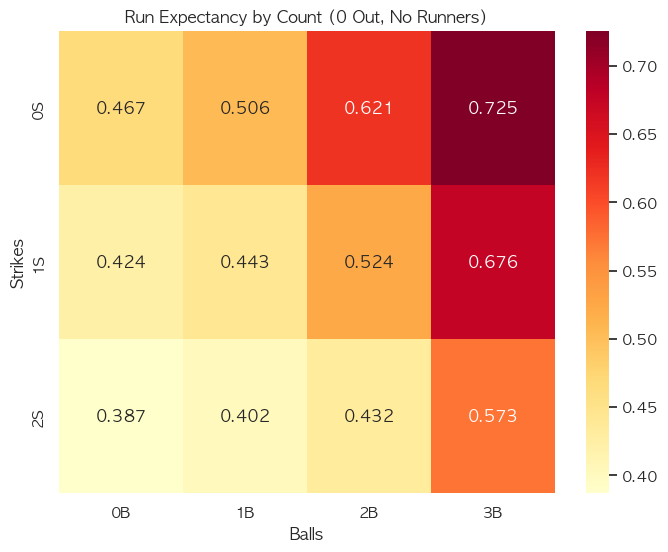

[INFO] Visualization Complete. Darker red means higher run expectancy (Crisis for pitcher).


In [6]:
# Path to RE288 table
re_path = cfg.PROCESSED_DATA_DIR / "re288_table.csv"
re_matrix = {}

# 1. Load RE288 Data
if re_path.exists():
    print(f"[INFO] Found existing RE288 table at: {re_path}")
    try:
        re_df = pd.read_csv(re_path)
        # Convert dataframe to dictionary for faster lookup: key='B-S-O-1-2-3', value=RE
        re_matrix = dict(zip(re_df['state'], re_df['re_value']))
        print(f"[INFO] Successfully loaded {len(re_matrix)} states.")
    except Exception as e:
        print(f"[ERROR] Failed to read CSV: {e}")
else:
    print("[WARNING] RE288 table file not found.")
    print("[INFO] Using default hardcoded RE matrix (Fallback).")
    # Fallback: Default RE Matrix (Approximate values for MLB 2010-2015)
    # Keys: (Balls, Strikes, Outs, 1B, 2B, 3B) -> mapped to string format later if needed
    # Here we just use a small sample for visualization if file is missing
    re_matrix = {
        '0-0-0-0-0-0': 0.48, '1-0-0-0-0-0': 0.57, '2-0-0-0-0-0': 0.69, '3-0-0-0-0-0': 0.89,
        '0-1-0-0-0-0': 0.43, '1-1-0-0-0-0': 0.50, '2-1-0-0-0-0': 0.62, '3-1-0-0-0-0': 0.82,
        '0-2-0-0-0-0': 0.37, '1-2-0-0-0-0': 0.42, '2-2-0-0-0-0': 0.51, '3-2-0-0-0-0': 0.70
    }

# 2. Visualization (Heatmap for 0 Out, No Runners)
# We will visualize how Run Expectancy changes by Ball-Strike Count
print(">>> [INFO] Generating RE288 Heatmap (0 Out, Bases Empty)...")

# Prepare grid data (3 Strikes x 4 Balls)
heatmap_data = np.zeros((3, 4)) 

for b in range(4):
    for s in range(3):
        # Key format: "Balls-Strikes-Outs-1B-2B-3B"
        key = f"{b}-{s}-0-0-0-0"
        
        # Handle both CSV loaded keys (strings) and fallback keys
        if key in re_matrix:
            heatmap_data[s, b] = re_matrix[key]
        else:
            heatmap_data[s, b] = 0.0 # Should not happen if table is complete

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=['0B', '1B', '2B', '3B'], 
            yticklabels=['0S', '1S', '2S'])

plt.title("Run Expectancy by Count (0 Out, No Runners)")
plt.xlabel("Balls")
plt.ylabel("Strikes")
plt.show()

print("[INFO] Visualization Complete. Darker red means higher run expectancy (Crisis for pitcher).")

>>> [INFO] Starting RL-based data filtering...
[Info] RE288 Table loaded (288 states)
[INFO] Calculating rewards and filtering data (Behavioral Cloning)...
[RL] Filtering Data: 1086 -> 508 (Threshold: 0.0390)
----------------------------------------
[INFO] Original Data Size: 1089
[INFO] Filtered Data Size: 508 (Top 50% based on Reward)
----------------------------------------
>>> [INFO] Visualizing Reward Distribution...


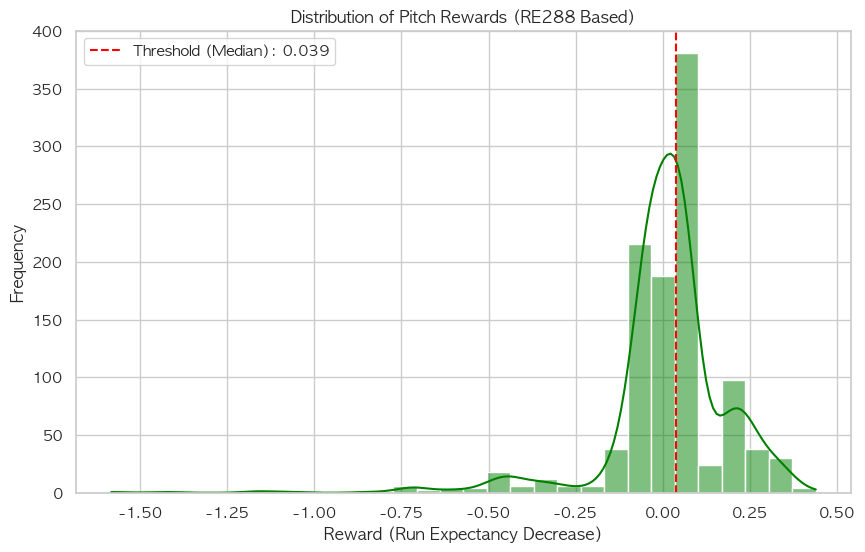

[INFO] Data filtering complete. The model will learn only from the data on the right side of the red line.


In [7]:
print(">>> [INFO] Starting RL-based data filtering...")

# 1. Initialize Feature Engineer
# This will automatically load the RE288 table created in Cell 3
engineer = FeatureEngineer()

# 2. Create Features with RL Filter
# use_rl_filter=True: Calculates rewards and keeps only the top 50% (good pitches)
print("[INFO] Calculating rewards and filtering data (Behavioral Cloning)...")
X_rl, y_type_rl, le_type, y_locs_rl = engineer.create_features(df_raw, is_training=True, use_rl_filter=True)

print("-" * 40)
print(f"[INFO] Original Data Size: {len(df_raw)}")
print(f"[INFO] Filtered Data Size: {len(X_rl)} (Top 50% based on Reward)")
print("-" * 40)

# 3. Visualization: Reward Distribution
# We recalculate rewards for the entire dataset just for visualization purposes
print(">>> [INFO] Visualizing Reward Distribution...")

# Use a temporary dataframe to calculate rewards for all rows
df_temp = engineer.preprocess(df_raw)
# Apply reward calculation (might take a moment)
all_rewards = df_temp.apply(engineer.calculate_reward, axis=1)

plt.figure(figsize=(10, 6))
sns.histplot(all_rewards, kde=True, color="green", bins=30)

# Mark the threshold (Median)
threshold = all_rewards.median()
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold (Median): {threshold:.3f}')

plt.title("Distribution of Pitch Rewards (RE288 Based)")
plt.xlabel("Reward (Run Expectancy Decrease)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print("[INFO] Data filtering complete. The model will learn only from the data on the right side of the red line.")

>>> [INFO] Starting Phase 5: Model Training...
[INFO] Training Pitch Type Model (Random Forest)...
[SYSTEM] Detected Processor: arm64 (arm)
[SYSTEM] Available CPU Cores: 10
[SYSTEM] Using all 10 cores for parallel processing (n_jobs=-1)
[INFO] Training Set: (406, 11), Test Set: (102, 11)
[INFO] Starting training on M4 Neural Engine/CPU...
[INFO] Training Complete!
[INFO] Model saved to /Users/songdongseon/projects/prototype/models/pitch_model_rl.joblib
[INFO] Training Pitch Location Model (Multi-Output Regression)...
[Location] Training Location Model...
[Location] Model RMSE: 0.6207 ft
[INFO] Location Model saved to /Users/songdongseon/projects/prototype/models/location_model.joblib
----------------------------------------
[INFO] All models trained and saved successfully.
----------------------------------------
>>> [INFO] Generating Strategic Visualization...
⚾ Scenario: 2 Strikes, 0 Balls
👉 Recommended Pitch: FF (Probability: 28.7%)
👉 Target Coordinates: X=0.03, Z=3.43


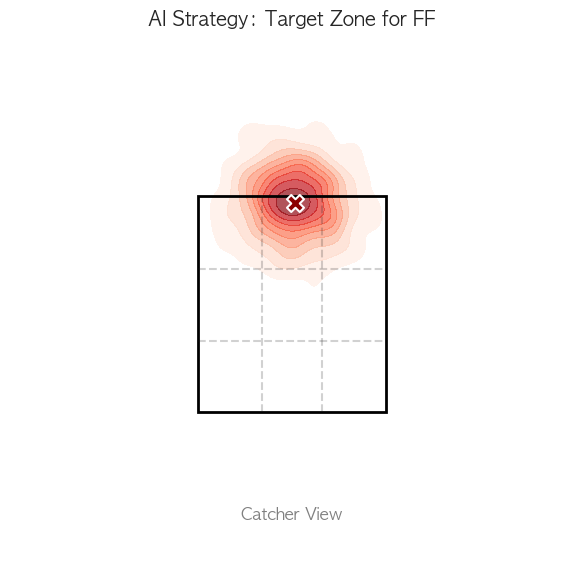

In [8]:
print(">>> [INFO] Starting Phase 5: Model Training...")

# 1. Train Pitch Type Model (Classification)
print("[INFO] Training Pitch Type Model (Random Forest)...")
type_trainer = PitchRecommendationTrainer()
# Train with filtered data (X_rl, y_type_rl)
type_results = type_trainer.train(X_rl, y_type_rl)
type_trainer.save_model("pitch_model_rl.joblib")

# 2. Train Pitch Location Model (Regression)
print("[INFO] Training Pitch Location Model (Multi-Output Regression)...")
# Prepare input for location model (add pitch type as feature)
X_loc = X_rl.copy()
X_loc['pitch_type_code'] = y_type_rl # Ground truth pitch type used for training

loc_trainer = PitchLocationTrainer()
loc_trainer.train(X_loc, y_locs_rl)
loc_trainer.save_model("location_model.joblib")

print("-" * 40)
print("[INFO] All models trained and saved successfully.")
print("-" * 40)

# 3. Visualization: Strategic Demo (2 Strikes Scenario)
print(">>> [INFO] Generating Strategic Visualization...")

def visualize_strategic_location(pred_loc, pitch_name):
    """Visualizes the AI target location with a gradient heatmap on the strike zone."""
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Draw Strike Zone (approx. width 17 inches = 1.42 ft)
    rect = patches.Rectangle((-0.83, 1.5), 1.66, 2.0, linewidth=2, edgecolor='black', facecolor='none', zorder=5)
    ax.add_patch(rect)
    
    # Draw Internal Grid Lines
    ax.plot([-0.27, -0.27], [1.5, 3.5], 'k--', alpha=0.2, zorder=5)
    ax.plot([0.27, 0.27], [1.5, 3.5], 'k--', alpha=0.2, zorder=5)
    ax.plot([-0.83, 0.83], [2.16, 2.16], 'k--', alpha=0.2, zorder=5)
    ax.plot([-0.83, 0.83], [2.83, 2.83], 'k--', alpha=0.2, zorder=5)
    
    # Generate Synthetic Data around Predicted Point for Heatmap Effect
    mean = pred_loc
    cov = [[0.08, 0], [0, 0.08]] # Variance for the 'glow' effect
    x_synth, y_synth = np.random.multivariate_normal(mean, cov, 1000).T
    
    # Plot Heatmap (Gradient)
    sns.kdeplot(x=x_synth, y=y_synth, fill=True, cmap="Reds", alpha=0.7, levels=10, thresh=0.05, ax=ax, zorder=2)
    
    # Plot Target Point
    ax.scatter(pred_loc[0], pred_loc[1], color='darkred', s=150, marker='X', edgecolors='white', linewidth=1.5, zorder=10, label='AI Target')

    # Settings
    ax.text(0, 0.5, "Catcher View", ha='center', color='gray')
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(0, 5.0)
    ax.set_title(f"AI Strategy: Target Zone for {pitch_name}", fontsize=14, fontweight='bold')
    ax.axis('off') # Clean look
    plt.tight_layout()
    plt.show()

# --- Demo Scenario: 2 Strikes, 0 Balls (Pitcher's Advantage) ---
# Create a dummy input (copy structure from X_rl)
demo_input = X_rl.iloc[0:1].copy()
demo_input['balls'] = 0
demo_input['strikes'] = 2
demo_input['on_1b'] = 0 # No runners

# 3-1. Recommend Pitch Type
probs = type_trainer.model.predict_proba(demo_input)[0]
best_idx = np.argmax(probs)
best_pitch_name = le_type.inverse_transform([best_idx])[0]

print(f"⚾ Scenario: 2 Strikes, 0 Balls")
print(f"👉 Recommended Pitch: {best_pitch_name} (Probability: {probs[best_idx]*100:.1f}%)")

# 3-2. Recommend Location
# Add the recommended pitch type to input
demo_input_loc = demo_input.copy()
demo_input_loc['pitch_type_code'] = best_idx

pred_loc = loc_trainer.model.predict(demo_input_loc)[0]
print(f"👉 Target Coordinates: X={pred_loc[0]:.2f}, Z={pred_loc[1]:.2f}")

# 3-3. Show Graph
visualize_strategic_location(pred_loc, best_pitch_name)